## 1) AirBnB London : Predicting rental price

This case study centers on predicting rental prices for apartments listed on Airbnb in London. Our aim is to forecast prices based on property features, aiding in various business decisions. This includes estimating revenue from property investments and finding reasonably priced accommodations in different neighborhoods. With a dataset of 51,646 observations, we've selected 33 London boroughs as variables, considering a range of factors such as property type, room type, and amenities. We'll categorize variables as quantitative (prefixed with "n_") and qualitative (prefixed with "f_") to create an efficient predictive model.

In [1]:
# load packages

## common packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import time


from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.regularizers import l2, l1
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

from deap import base, creator, tools, algorithms

# This will clear our output in the NN part
from IPython.display import clear_output 
from IPython.display import display, Markdown

## AirBnB London
from scipy import stats
from scipy.stats import chi2_contingency

# Parameters of our Notebook:
Run_Code = True
seed = 42
cv_fold = 5

Using TensorFlow backend


In [2]:
# graph features
plt.style.use('seaborn-v0_8-deep')
theme_color = "#ADD8E6" #lightblue
color_theme = "lightblue"

# for an automatic numerotation
graph_count = 1
table_count = 1

def graph_increment():
    global graph_count
    value = graph_count
    graph_count += 1
    return value


def table_increment():
    global table_count
    value = table_count
    table_count += 1
    return value

def table_name(name):
    title = f"*Table {table_increment()} : {name}* \n"
    return display(Markdown(title))
def graph_name(name):
    title = f"*Graph {graph_increment()} : {name}* \n"
    return display(Markdown(title))

In [3]:
start_time_project = time.time()

In [4]:
df = pd.read_csv('airbnb_london_homework.csv')

### 1.1) Data wrangling and data visualization :

In this section, we focus on the essential processes of data preparation and visualization specific to the Airbnb case. Data wrangling involves cleaning, structuring, and enhancing the dataset, while data visualization unveils key insights through graphical representations. These pivotal steps lay the groundwork for our predictive modeling and facilitate a deeper understanding of the Airbnb dataset.

In [5]:
table_name("Data Frame Head")
df.head()

*Table 1 : Data Frame Head* 


,f_property_type,f_room_type,f_cancellation_policy,f_bed_type,f_neighbourhood_cleansed,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,...,d_selfcheckin,d_shampoo,d_smartlock,d_smokedetector,d_smokingallowed,d_suitableforevents,d_tv,d_washer,d_washerdryer,d_wheelchairaccessible
0,Apartment,Private room,flexible,Real Bed,Kingston upon Thames,23,1,1.0,100,1,...,0,0,0,1,0,0,0,1,0,0
1,Apartment,Private room,moderate,Couch,Kingston upon Thames,50,2,1.0,91,15,...,0,0,0,1,0,0,1,0,0,0
2,Apartment,Private room,flexible,Real Bed,Kingston upon Thames,24,2,1.0,80,2,...,0,0,0,1,0,0,0,1,0,0
3,House,Private room,flexible,Real Bed,Kingston upon Thames,50,2,1.5,94,0,...,0,0,0,1,0,0,1,1,0,0
4,House,Private room,flexible,Real Bed,Kingston upon Thames,25,1,1.0,94,0,...,0,1,0,0,0,0,0,1,0,0


In [6]:
nrow, ncol = df.shape
print("Number of row :", nrow,"\n"
      "Number of column :", ncol)

Number of row : 51646 
Number of column : 65


In [7]:
table_name('Column information')
round(df.describe(),2)

*Table 2 : Column information* 


,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,d_selfcheckin,d_shampoo,d_smartlock,d_smokedetector,d_smokingallowed,d_suitableforevents,d_tv,d_washer,d_washerdryer,d_wheelchairaccessible
count,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,...,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00
mean,94.88,3.06,1.26,92.44,12.35,1.42,1.14,6.67,3.31,1.71,...,0.04,0.57,0.00,0.78,0.08,0.03,0.67,0.84,0.00,0.06
std,80.93,1.89,0.53,8.44,25.86,1.04,1.24,12.69,29.08,1.17,...,0.20,0.49,0.04,0.42,0.27,0.16,0.47,0.37,0.03,0.25
min,8.00,1.00,0.00,20.00,0.00,1.00,0.01,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,43.00,2.00,1.00,92.00,0.00,1.00,0.47,0.00,1.00,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
50%,74.00,2.00,1.00,94.00,3.00,1.00,0.77,0.00,2.00,1.00,...,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
75%,120.00,4.00,1.50,97.00,12.00,1.00,1.17,10.00,3.00,2.00,...,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
max,999.00,16.00,8.00,100.00,396.00,16.00,15.00,240.00,5000.00,16.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [8]:
selected_columns_f = [col for col in df.columns if col.startswith('f_')]
selected_columns_n = [col for col in df.columns if col.startswith('n_')]
selected_columns_d = [col for col in df.columns if col.startswith('d_')]

# Function to create a DataFrame with data types and NA info
def create_info_df(columns, df):
    data_types = df[columns].dtypes
    has_na = df[columns].isna().any()
    info_df = pd.DataFrame({'Columns': columns, 'Data Types': data_types, 'Has NA': has_na})
    return info_df

# Create DataFrames for each group
info_df_f = create_info_df(selected_columns_f, df).reset_index(drop = True)
info_df_n = create_info_df(selected_columns_n, df).reset_index(drop = True)
info_df_d = create_info_df(selected_columns_d, df).reset_index(drop = True)

# Now you have three DataFrames (info_df_f, info_df_n, info_df_d) with the desired information.
info_df = pd.concat([info_df_f, info_df_d,info_df_n], axis = 0)
pd.set_option('display.max_rows', None)
table_name("Data type information")
info_df

*Table 3 : Data type information* 


,Columns,Data Types,Has NA
0,f_property_type,object,False
1,f_room_type,object,False
2,f_cancellation_policy,object,False
3,f_bed_type,object,False
4,f_neighbourhood_cleansed,object,False
0,d_24hourcheckin,int64,False
1,d_airconditioning,int64,False
2,d_breakfast,int64,False
3,d_buzzerwirelessintercom,int64,False
4,d_cabletv,int64,False


In [9]:
pd.set_option('display.max_rows', 20) #if we don't run this our notebook will not run!
print('There is',df[selected_columns_d].shape[1], 'dummies variable')

There is 49 dummies variable


We can observe that there are no missing values, and both qualitative and quantitative variables have the appropriate data types.

The 49 dummy variables currently have a data type of int64, which uses 64 bytes of memory each. To conserve memory, we will change their data types to bool.

In [10]:
for col in selected_columns_d:
    # Handle missing values if any
    df[col] = df[col].astype('bool')

In [11]:
table_name("Quantitative column information")

round(df[selected_columns_n].describe(),2)

*Table 4 : Quantitative column information* 


,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,n_days_since
count,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00,51646.00
mean,3.06,1.26,92.44,12.35,1.42,1.14,6.67,3.31,1.71,418.13
std,1.89,0.53,8.44,25.86,1.04,1.24,12.69,29.08,1.17,344.65
min,1.00,0.00,20.00,0.00,1.00,0.01,0.00,1.00,0.00,0.00
25%,2.00,1.00,92.00,0.00,1.00,0.47,0.00,1.00,1.00,228.00
50%,2.00,1.00,94.00,3.00,1.00,0.77,0.00,2.00,1.00,327.00
75%,4.00,1.50,97.00,12.00,1.00,1.17,10.00,3.00,2.00,504.00
max,16.00,8.00,100.00,396.00,16.00,15.00,240.00,5000.00,16.00,2722.00


Let's check the histogram of our quantitative features :

*Graph 1 : Quantitative features histogram* 


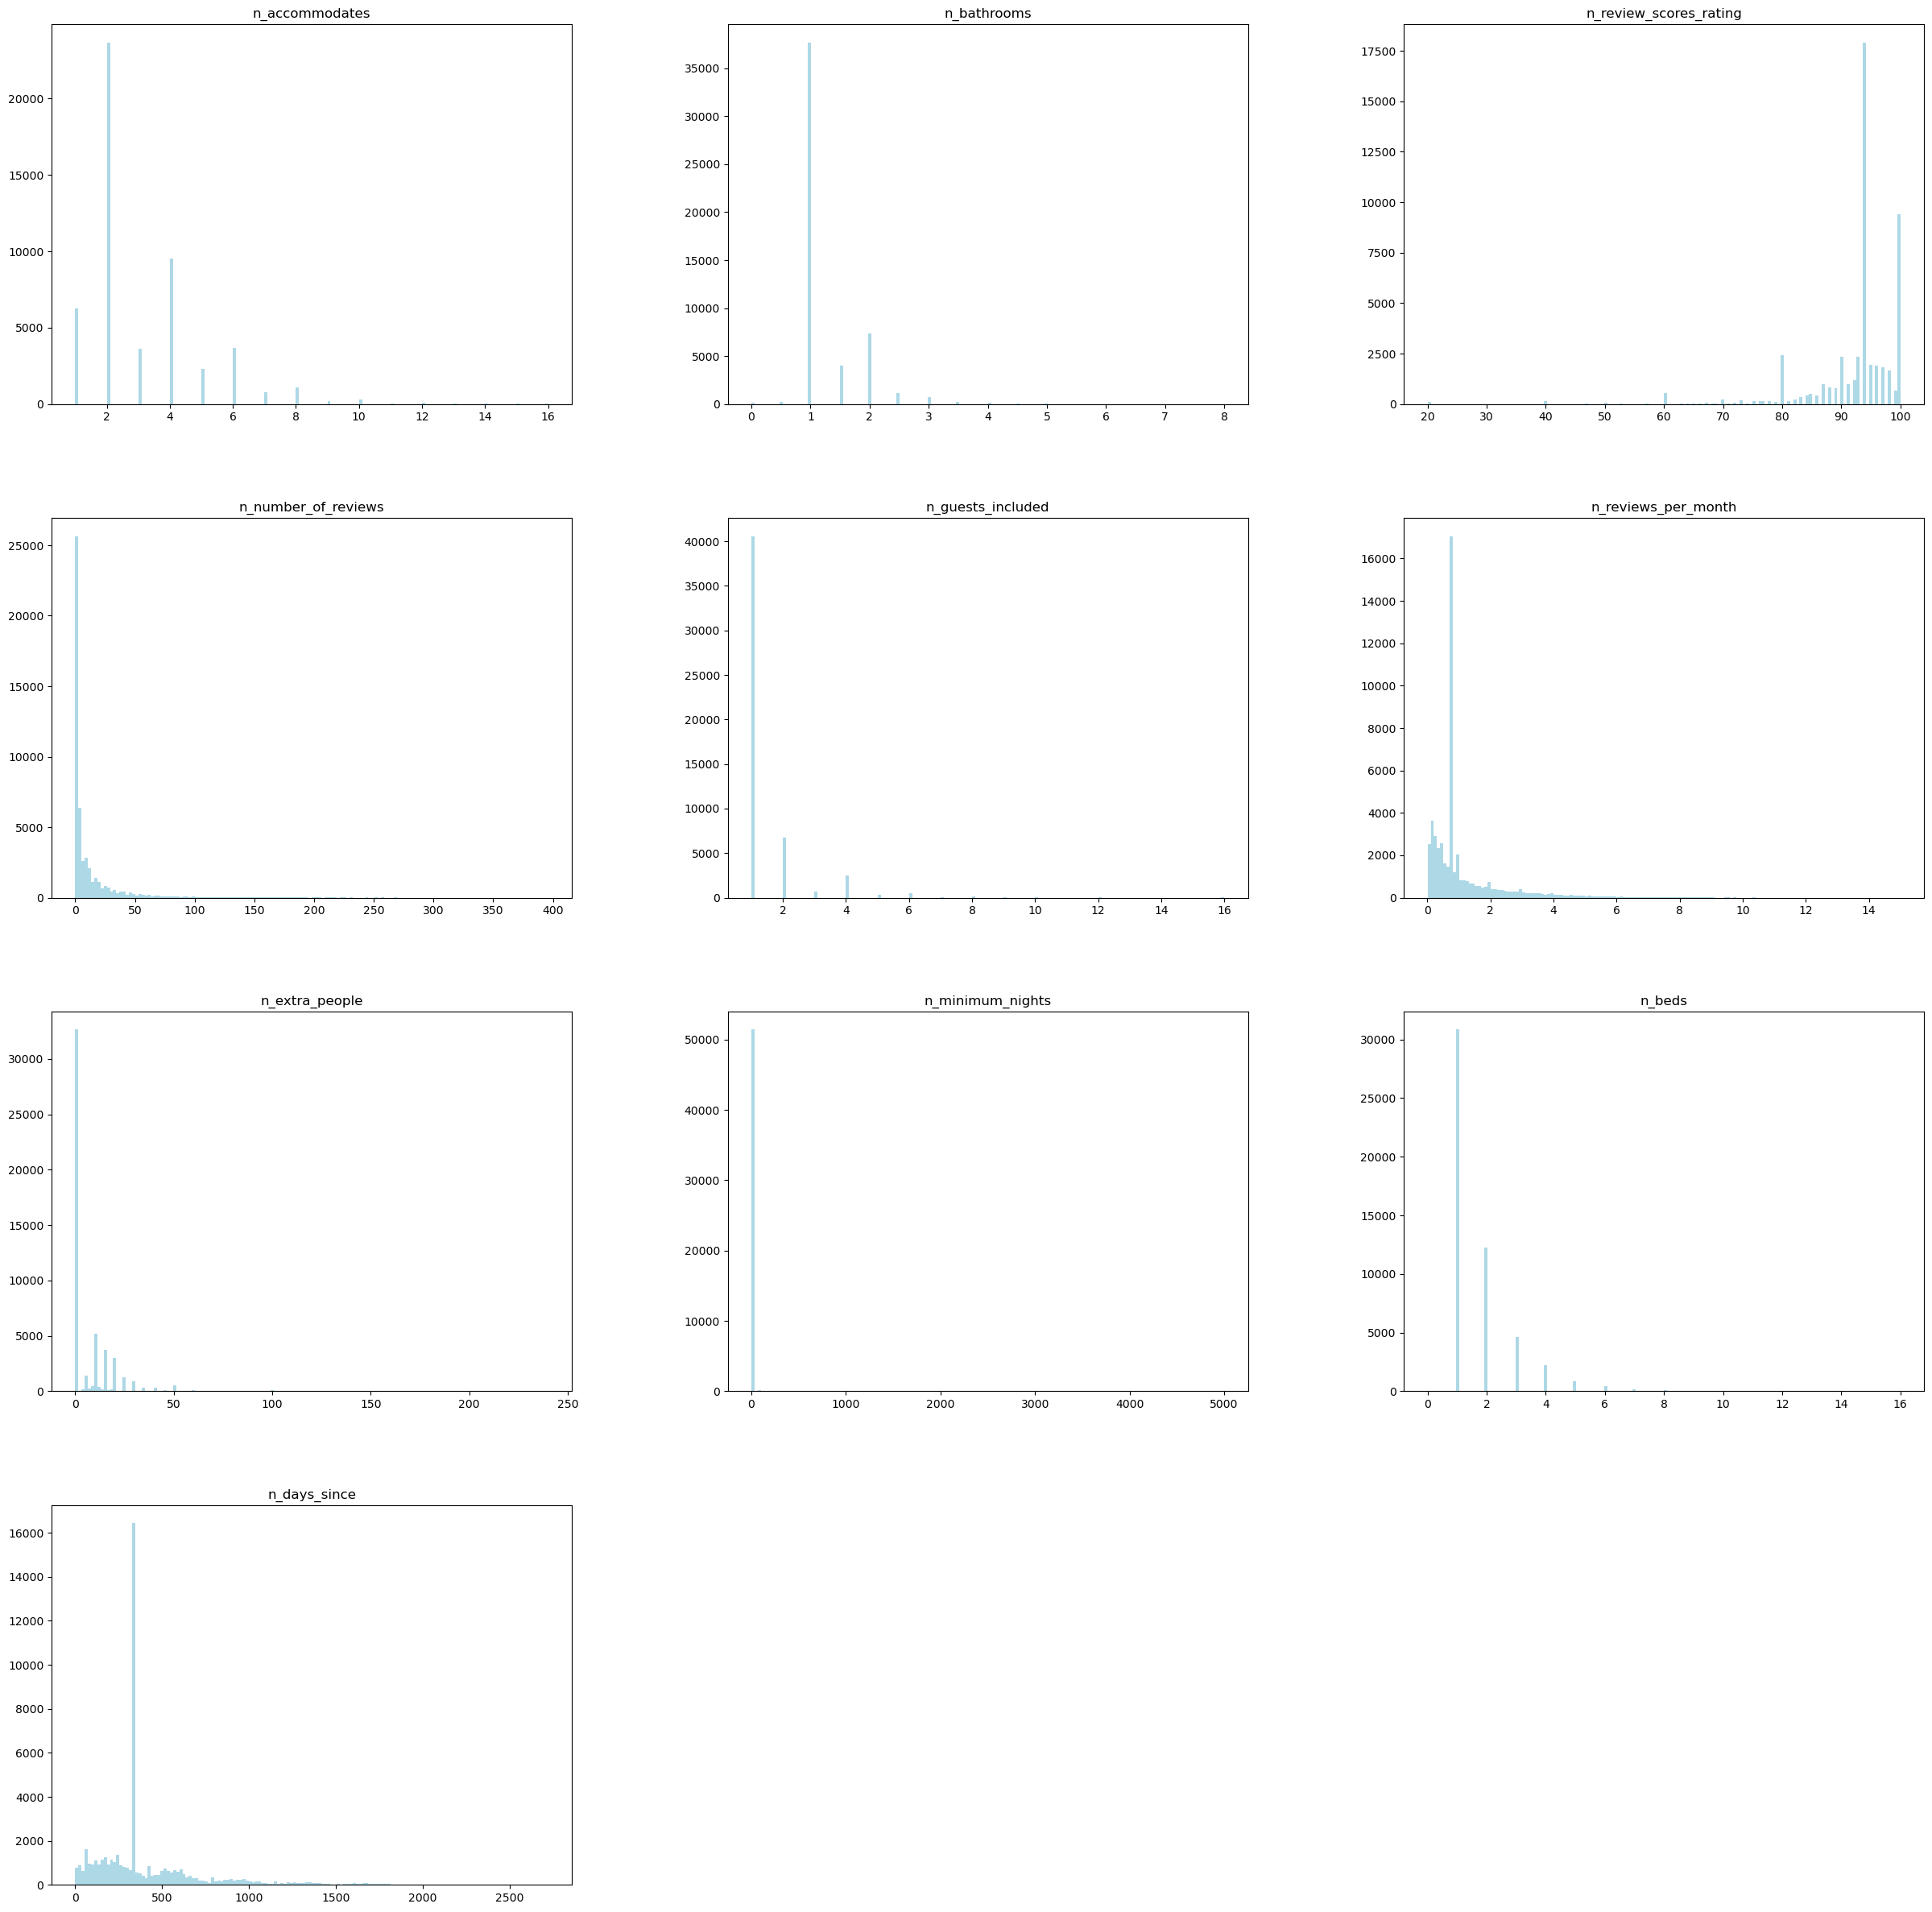

In [12]:
graph_name('Quantitative features histogram')

df[selected_columns_n].hist(color = color_theme, figsize = (30,30), grid = False, bins = 150);

The same for boolean features :

*Graph 2 : Qualitative features histogram* 


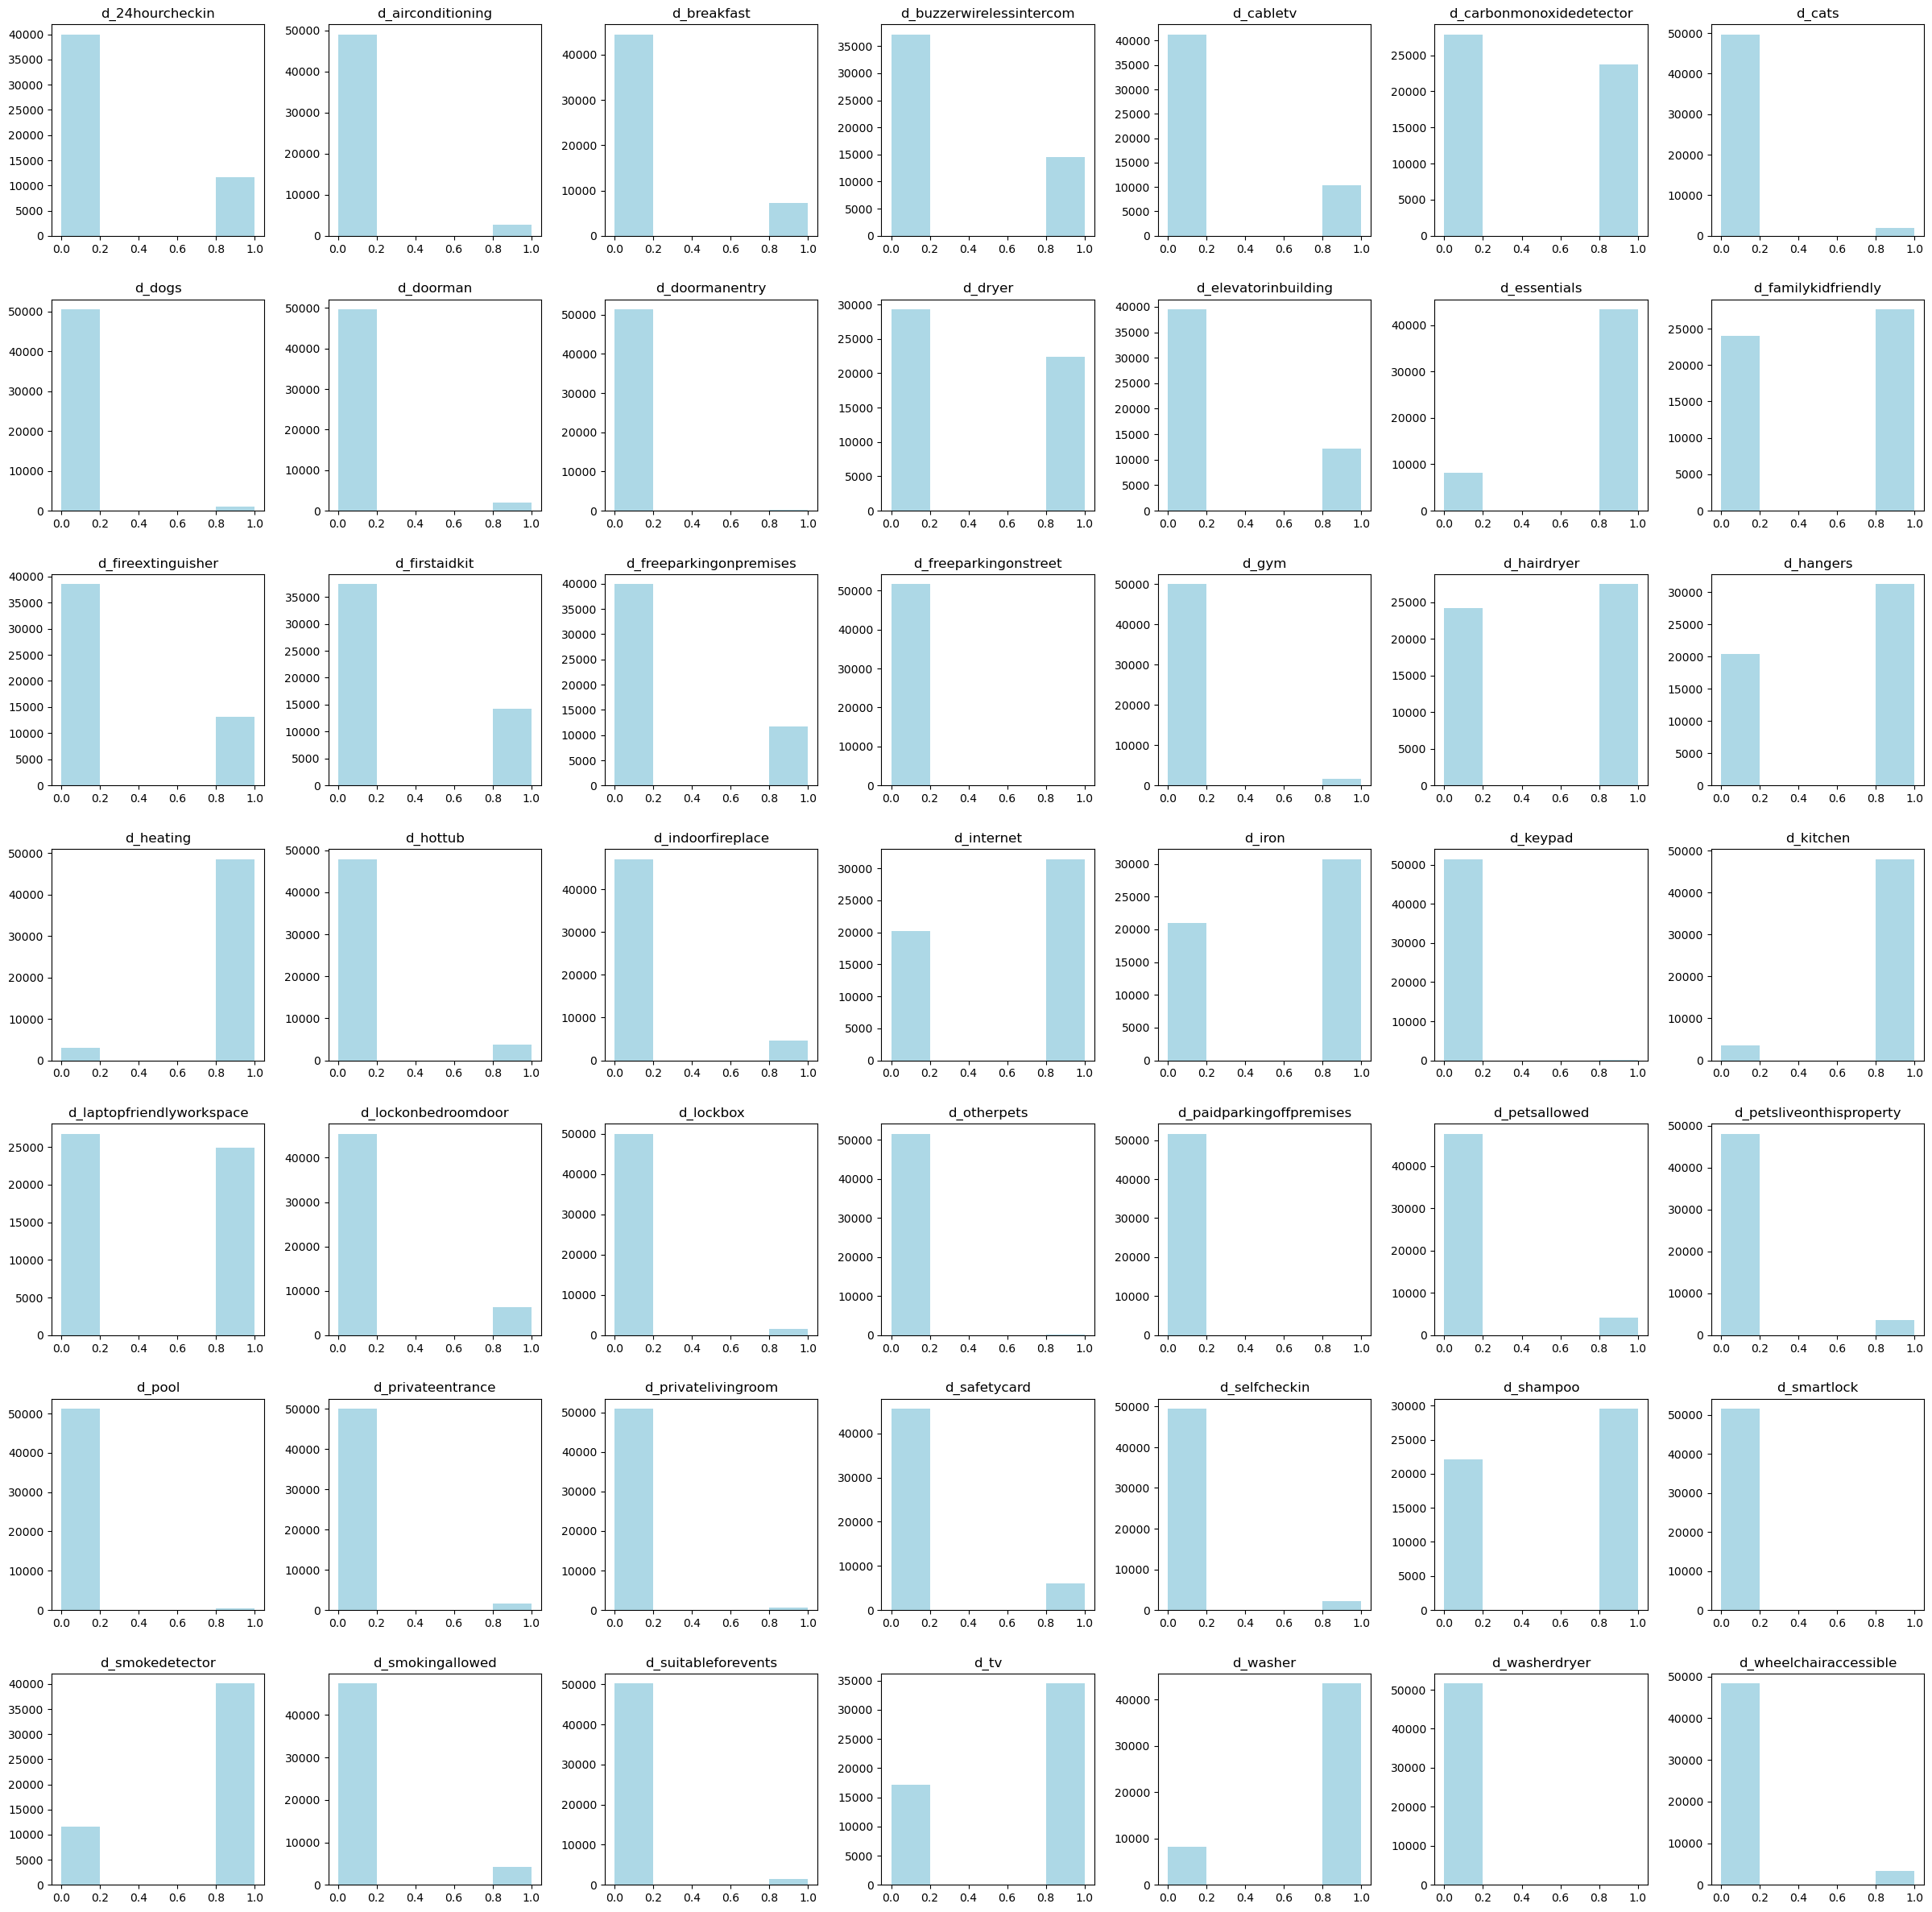

In [13]:
graph_name("Qualitative features histogram")


df = df.replace({False : 0, True : 1})
df[selected_columns_d].hist(color = color_theme, figsize = (30,30), grid = False, bins = 5);

We will compile a list of features that exhibit correlations close to zero, or in the case of non-quantitative features, are statistically significant in t-test or ANOVA tests. For linear classifiers like linear regression, we will remove these features. However, for non-linear classifiers capable of capturing complex relationships within the learning model, omitting these columns might unintentionally exclude valuable information that the model can leverage.

*Graph 3 : Correlation Heatmap* 


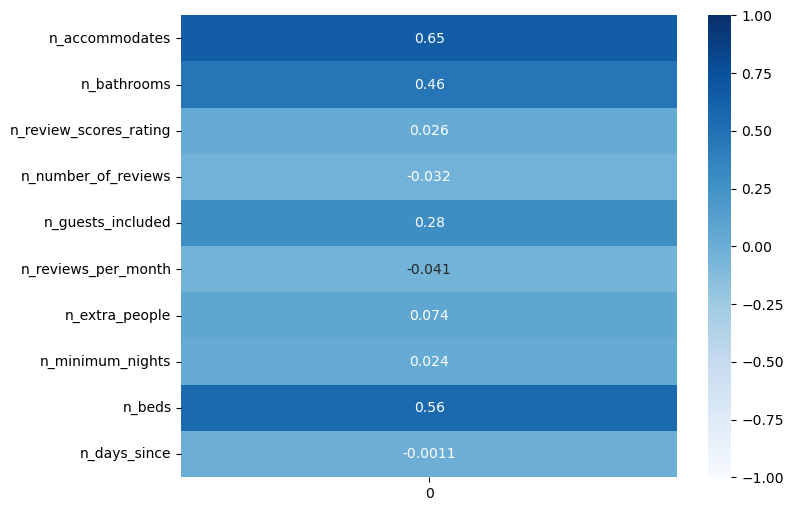

Correlation Columns with usd_price_day [('n_accommodates', 0.6489524427264538), ('n_beds', 0.5611478257612806), ('n_bathrooms', 0.4625743083036801), ('n_guests_included', 0.27710201039591514), ('n_extra_people', 0.07369865999319064), ('n_reviews_per_month', -0.04070877786912352), ('n_number_of_reviews', -0.03165823509742117), ('n_review_scores_rating', 0.026065398461563357), ('n_minimum_nights', 0.024322500225114778), ('n_days_since', -0.0010687631410686597)]
----------------------------
Columns below threshold : ['n_days_since']


In [14]:
col_to_drop = [] 

correlation = df[selected_columns_n].corrwith(df['usd_price_day'])
# Create a list of tuples containing column name and correlation value
correlation_tuples = [(col, correlation[col]) for col in correlation.index]

# Sort the list of tuples based on the absolute correlation value
sorted_correlation_tuples = sorted(correlation_tuples, key=lambda x: abs(x[1]), reverse=True)

columns_below_threshold = [col for col in correlation.index if abs(correlation[col]) < 0.01]
col_to_drop = col_to_drop + columns_below_threshold



graph_name("Correlation Heatmap")
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation.to_frame(), annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.show()

# Print the sorted list of tuples
print('Correlation Columns with usd_price_day',sorted_correlation_tuples)
print('----------------------------')
print('Columns below threshold :', columns_below_threshold)

The code is designed to perform t-tests to determine if certain selected columns in the AirBNB data frame have a significant impact on the 'usd_price_day' column. It does so using a 5% significance level. The code groups data based on boolean values (True/False) within the selected columns and executes t-tests to compare these groups against the 'usd_price_day' column. The results of these tests are saved in a list called t_test_results. The code then displays the t-statistic and p-value for each column and identifies variables that have a statistically significant impact on 'usd_price_day'. Additionally, the col_to_drop list is utilized to keep track of non-significant variables.

In [15]:
# Create a DataFrame containing the selected columns
selected_df = df.loc[:, selected_columns_d + ['usd_price_day']]

# Create groups for each boolean column (True/False)
groups = [selected_df[selected_df[col] == True]['usd_price_day'] for col in selected_df.columns]

# Perform a t-test to compare the groups (True vs. False) for each column
t_test_results = [stats.ttest_ind(group, selected_df['usd_price_day'], equal_var=False) for group in groups]

# Display the t-test results
for i, col in enumerate(selected_df.columns):
    t_statistic, p_value = t_test_results[i]
    if p_value >= 0.05:
        if col != 'usd_price_day':
            col_to_drop += [col]
            print(f"Variable: {col}")
            print(f"T-statistic: {round(t_statistic,3)}")
            print(f"P-value: {round(p_value,3)}")
            print("The variable does not have a significant effect on 'usd_price_day'.")
            print("----------------------------")

Variable: d_firstaidkit
T-statistic: 1.163
P-value: 0.245
The variable does not have a significant effect on 'usd_price_day'.
----------------------------
Variable: d_heating
T-statistic: 1.56
P-value: 0.119
The variable does not have a significant effect on 'usd_price_day'.
----------------------------
Variable: d_otherpets
T-statistic: -1.4
P-value: 0.164
The variable does not have a significant effect on 'usd_price_day'.
----------------------------
Variable: d_paidparkingoffpremises
T-statistic: 0.479
P-value: 0.637
The variable does not have a significant effect on 'usd_price_day'.
----------------------------
Variable: d_smartlock
T-statistic: 1.112
P-value: 0.269
The variable does not have a significant effect on 'usd_price_day'.
----------------------------


There is 5 variables that are not significant to the target feature 'usd_price_day'

The code is designed to perform chi-squared tests for specific columns in the dataset, specifically evaluating their relationship with the 'usd_price_day' column. It constructs contingency tables for each selected column and 'usd_price_day,' computes the chi-squared statistic and p-value, and stores these results in a list. The code then iterates through the results, printing information about each variable. If a variable's p-value is below the 5% significance level, it is considered to have a significant effect on 'usd_price_day.' Otherwise, the variable is added to a list named col_to_drop, indicating that it doesn't significantly impact 'usd_price_day'.

In [16]:
# Create a DataFrame containing the selected columns
selected_df = df.loc[:, selected_columns_f + ['usd_price_day']]

# Perform a chi-squared test for each column
chi2_test_results = []

for col in selected_df.columns:
    if col != 'usd_price_day':
        contingency_table = pd.crosstab(selected_df[col], selected_df['usd_price_day'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi2_test_results.append((col, chi2, p))

# Display the chi-squared test results
for col, chi2, p in chi2_test_results:
    print(f"Variable: {col}")
    print(f"Chi-squared statistic: {round(chi2,3)}")
    print(f"P-value: {round(p,1)}")
    if p < 0.05:  # 5% significance level
        print("The variable has a significant effect on 'usd_price_day'.")
    else:
        col_to_drop += [col]
        print("The variable does not have a significant effect on 'usd_price_day'.")
    print("----------------------------")


Variable: f_property_type
Chi-squared statistic: 5014.69
P-value: 0.0
The variable has a significant effect on 'usd_price_day'.
----------------------------
Variable: f_room_type
Chi-squared statistic: 38493.07
P-value: 0.0
The variable has a significant effect on 'usd_price_day'.
----------------------------
Variable: f_cancellation_policy
Chi-squared statistic: 5156.739
P-value: 0.0
The variable has a significant effect on 'usd_price_day'.
----------------------------
Variable: f_bed_type
Chi-squared statistic: 617.338
P-value: 0.0
The variable has a significant effect on 'usd_price_day'.
----------------------------
Variable: f_neighbourhood_cleansed
Chi-squared statistic: 27694.168
P-value: 0.0
The variable has a significant effect on 'usd_price_day'.
----------------------------


In [17]:
df_ = df.drop(col_to_drop, axis = 1)
selected_columns_f = [col for col in df_.columns if col.startswith('f_')]
selected_columns_n = [col for col in df_.columns if col.startswith('n_')]
selected_columns_d = [col for col in df_.columns if col.startswith('d_')]

print('List of the columns to drop :', col_to_drop)

List of the columns to drop : ['n_days_since', 'd_firstaidkit', 'd_heating', 'd_otherpets', 'd_paidparkingoffpremises', 'd_smartlock']


*Graph 4 : Distribution of USD Price Day* 


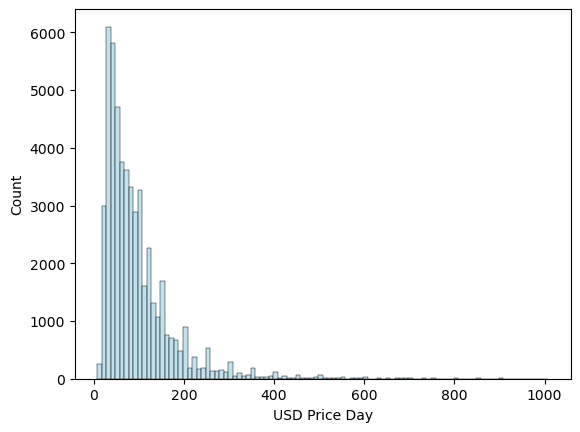

Skewness = 3.1673039705506523


In [18]:
ax = sns.histplot(data=df, x='usd_price_day', stat='count',
                  color = theme_color,
                 binwidth = 10)
graph_name("Distribution of USD Price Day")


# Set labels and title
ax.set(xlabel='USD Price Day', ylabel='Count')
# Show the plot
plt.show();

print('Skewness =', stats.skew(df['usd_price_day']))

It seems that the distribtuion of the rental price didn't follow a gaussian distribution. We can see that we have a positive skewness. \
A positive skewness in the rental price distribution indicates that the majority of rental properties in the area are relatively affordable, with only a few high-end rentals contributing to the right-skewed shape of the distribution.

Let's create the different data set that we will use for the rest :

In [19]:
def categorical_to_integer(df, column_name):
    unique_categories = df[column_name].unique()
    category_to_int = {category: i for i, category in enumerate(unique_categories)}
    df[column_name] = df[column_name].map(category_to_int)
    return df


def dummies_col_to_drop(df):
    global selected_columns_d, selected_columns_f, selected_columns_n
    df_new = df.copy()
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    df_new = df_new.drop(col_to_drop, axis = 1)
    df_new = pd.get_dummies(df_new, columns=selected_columns_f)
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    selected_columns_n = [col for col in df_new.columns if col.startswith('n_')]
    selected_columns_d = [col for col in df_new.columns if col.startswith('d_')]
    return(df_new)

def dummies_not_col_to_drop(df):
    global selected_columns_d, selected_columns_f, selected_columns_n
    df_new = df.copy()
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    df_new = pd.get_dummies(df_new, columns=selected_columns_f)
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    selected_columns_n = [col for col in df_new.columns if col.startswith('n_')]
    selected_columns_d = [col for col in df_new.columns if col.startswith('d_')]    
    return(df_new)

def integer_col_to_drop(df):
    global selected_columns_d, selected_columns_f, selected_columns_n
    df_new = df.copy()
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    df_new = df_new.drop(col_to_drop, axis = 1)
    for col in selected_columns_f:
        df_new = categorical_to_integer(df_new,col)
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    selected_columns_n = [col for col in df_new.columns if col.startswith('n_')]
    selected_columns_d = [col for col in df_new.columns if col.startswith('d_')]
    return(df_new)

def integer_not_col_to_drop(df):
    global selected_columns_d, selected_columns_f, selected_columns_n
    df_new = df.copy()
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    for col in selected_columns_f:
        df_new = categorical_to_integer(df_new,col)
    selected_columns_f = [col for col in df_new.columns if col.startswith('f_')]
    selected_columns_n = [col for col in df_new.columns if col.startswith('n_')]
    selected_columns_d = [col for col in df_new.columns if col.startswith('d_')]
    return(df_new)

def scale_data(df_new,col_to_scale):
    scaler = StandardScaler()

    # Find the names of the columns to scale
    columns_to_scale = [col for col in col_to_scale if col in df_new.columns]

    # Apply Z-score scaling to the specified columns
    df_new[columns_to_scale] = scaler.fit_transform(df_new[columns_to_scale])
    return(df_new)


### 1.2) Model Prediction :

In the preceding section, we generated three potential data sets for our analysis. Now, in this part, we will employ various models and evaluate their performance. Before proceeding, we will partition our dataset into training, testing, and evaluation sets with respective proportions of 70%, 15%, and 15%.

Our approach for each algorithm will be as follows:

1. Initially, we will identify the data set that performs the best with a base model.
2. Next, we will fine-tune the parameters and select the optimal configuration.
3. Finally, we will assess the performance of the best-tuned model on the evaluation set.

Ultimately, we will compare the performance of each algorithm.

#### a) **Linear Regression :**

We can't do a linear regression with a data like that, we need to change into integer our categorial features or into dummies features. Note that because we do a linear regression **we can drop the column** that we found in the data processing part.
Instead of changing them into integer, we will put them into dummies variable.

#### Data set selection :

**Qualitative variables into dummies :**

We will try here the data set when we drop the column selected before, and without dropping them

In [20]:
df_lr = dummies_col_to_drop(df)
print('Dimension :', df_lr.shape)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

# fit a linear model
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)

# MSE and RMSE :
mse_lr  = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)

print('MSE Linear Regression =', mse_lr)
print('--------------------------------')
print('RMSE Linear Regression =', rmse_lr)


Dimension : (51646, 97)
MSE Linear Regression = 2477.708431650026
--------------------------------
RMSE Linear Regression = 49.776585174658436


In [21]:
df_lr = dummies_not_col_to_drop(df)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

print('Dimension of df :', df.shape)
print('Dimension of df_lr :', df_lr.shape)

print('--------------------------------')

# fit a linear model
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)

# MSE and RMSE :
mse_lr2  = mean_squared_error(y_test,y_pred)
rmse_lr2 = np.sqrt(mse_lr2)

print('MSE Linear Regression (without droping columns) =', mse_lr2)
print('--------------------------------')
print('RMSE Linear Regression (without droping columns) =', rmse_lr2)


Dimension of df : (51646, 65)
Dimension of df_lr : (51646, 103)
--------------------------------
MSE Linear Regression (without droping columns) = 2476.6326533095526
--------------------------------
RMSE Linear Regression (without droping columns) = 49.76577793333038


**Qualitative variables into quantitative variables:**

Let's try to just put our qualitative parameters into quantitative one to see if it perform better than the stuff we did previously

In [22]:
df_lr = integer_col_to_drop(df)
    
X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)


# fit a linear model
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)

# MSE and RMSE :
mse_lr  = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)

print('MSE Linear Regression =', mse_lr)
print('--------------------------------')
print('RMSE Linear Regression =', rmse_lr)

MSE Linear Regression = 2753.5049732928182
--------------------------------
RMSE Linear Regression = 52.47385037609512


In [23]:
df_lr = integer_not_col_to_drop(df)
    
X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)


# fit a linear model
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)

# MSE and RMSE :
mse_lr  = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)

print('MSE Linear Regression (without droping columns) =', mse_lr)
print('--------------------------------')
print('RMSE Linear Regression (without droping columns) =', rmse_lr)

MSE Linear Regression (without droping columns) = 2751.8581296151046
--------------------------------
RMSE Linear Regression (without droping columns) = 52.45815598755931


We can see that, putting the qualitative variables into dummies perform better.

**Scale Data**:

It appears that transforming our categorical values into dummy variables yields better results. Now, let's assess how our algorithms perform when we scale the data.

In [24]:
df_lr = dummies_col_to_drop(df)
df_lr = scale_data(df_lr,selected_columns_n)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

# fit a linear model
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)

# MSE and RMSE :
mse_lr  = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)

print('MSE Linear Regression =', mse_lr)
print('--------------------------------')
print('RMSE Linear Regression =', rmse_lr)

MSE Linear Regression = 2480.2777280973683
--------------------------------
RMSE Linear Regression = 49.802386771091285


In [25]:
df_lr = dummies_not_col_to_drop(df)
df_lr = scale_data(df_lr,selected_columns_n)
print('Dimension :', df_lr.shape)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

# fit a linear model
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)

# MSE and RMSE :
mse_lr  = mean_squared_error(y_test,y_pred)
rmse_lr = np.sqrt(mse_lr)

print('MSE Linear Regression =', mse_lr)
print('--------------------------------')
print('RMSE Linear Regression =', rmse_lr)

Dimension : (51646, 103)
MSE Linear Regression = 2477.261251961445
--------------------------------
RMSE Linear Regression = 49.77209310408238


The algorithms perform slightly better when we scale the data. We will proceed to tune our parameters with the scaled data, focusing on the undropped columns. 

Next, let's continue by performing feature selection using a genetic algorithm.

**Features selection, Genetic Algorithm :**

Generation 1/15
Generation 2/15
Generation 3/15
Generation 4/15
Generation 5/15
Generation 6/15
Generation 7/15
Generation 8/15
Generation 9/15
Generation 10/15
Generation 11/15
Generation 12/15
Generation 13/15
Generation 14/15
Generation 15/15

--------------------------------
Selected Features : ['n_accommodates', 'n_bathrooms', 'n_review_scores_rating', 'n_number_of_reviews', 'n_guests_included', 'd_airconditioning', 'd_breakfast', 'd_cabletv', 'd_carbonmonoxidedetector', 'd_cats', 'd_doorman', 'd_dryer', 'd_elevatorinbuilding', 'd_essentials', 'd_fireextinguisher', 'd_freeparkingonpremises', 'd_freeparkingonstreet', 'd_gym', 'd_hangers', 'd_heating', 'd_hottub', 'd_indoorfireplace', 'd_laptopfriendlyworkspace', 'd_lockonbedroomdoor', 'd_lockbox', 'd_paidparkingoffpremises', 'd_petsliveonthisproperty', 'd_smartlock', 'd_smokedetector', 'd_suitableforevents', 'd_washer', 'd_washerdryer', 'd_wheelchairaccessible', 'f_room_type_Entire home/apt', 'f_cancellation_policy_flexible', 'f_ca

*Graph 5 : MSE Evolution* 


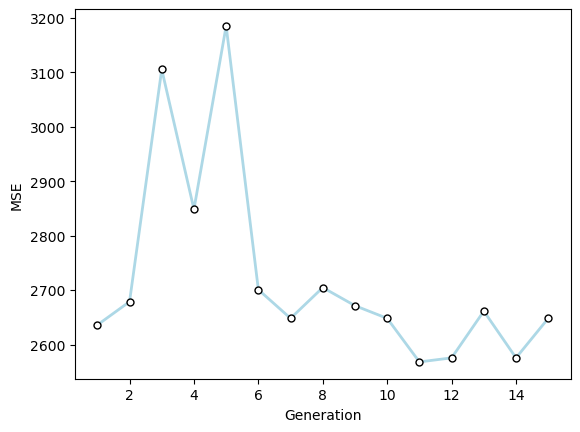

In [26]:
if True :
    df_lr = dummies_not_col_to_drop(df)
    df_lr = scale_data(df_lr,selected_columns_n)
    X = df_lr.drop(['usd_price_day'], axis = 1)
    y = df_lr['usd_price_day']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
    X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

    
    # Create a function to evaluate the fitness of an individual (subset of features)
    def evaluate(individual):
        selected_features = [feature for feature, is_selected in zip(X_train.columns, individual) if is_selected]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        model = LinearRegression()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        mse = mean_squared_error(y_test, y_pred)
        return mse,  # Ensure it returns a tuple with a single value

    v_mse = []

    # Create a DEAP toolbox for the GA
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()

    # Create a function to generate a random individual (subset of features)
    toolbox.register("attr_bool", np.random.choice, [0, 1], size=len(X_train.columns))
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_bool)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register genetic operators
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=5)

    # Set the GA parameters
    population_size = 150
    num_generations = 15
    crossover_prob  = 0.7
    mutation_prob   = 0.01

    # Initialize the population before the main GA loop
    population = toolbox.population(n=population_size)

    # Main GA loop
    for generation in range(num_generations):
        print(f"Generation {generation + 1}/{num_generations}")

        # Evaluate the fitness of each individual in the population
        for ind in population:
            ind.fitness.values = evaluate(ind)

        # Calculate the best MSE in this generation and store it
        best_mse = min(ind.fitness.values)
        v_mse.append(best_mse)

        # Select the next generation
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)

        # Replace the current population with the offspring
        population = toolbox.select(offspring, k=len(population))

    # Get the best individual from the final population
    best_individual = tools.selBest(population, k=1)[0]
    selected_features = [feature for feature, is_selected in zip(X_train.columns, best_individual) if is_selected]

    # Perform linear regression with the selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    model_selected_features = LinearRegression()
    model_selected_features.fit(X_train_selected, y_train)
    y_pred_selected_features = model_selected_features.predict(X_test_selected)

    # Calculate MSE and RMSE
    mse_lr_ga = mean_squared_error(y_test, y_pred_selected_features)
    rmse_lr_ga = np.sqrt(mse_lr_ga)
    print('\n--------------------------------')
    print('Selected Features :', selected_features)
    print('--------------------------------')
    print('MSE Linear Regression =', mse_lr_ga)
    print('--------------------------------')
    print('RMSE Linear Regression =', rmse_lr_ga)

    # Create a color palette with a single color '#FF6B6B' repeated for each generation
    salmon_palette = ['#FF6B6B'] * num_generations

    # Use Seaborn to set the color palette
    sns.set_palette(salmon_palette)

    # Create the plot with a black border around the line
    plt.plot(range(1, num_generations + 1), v_mse, marker='o',
             color=theme_color, markerfacecolor='w', markersize=5, markeredgecolor='k', lw=2)
    plt.xlabel('Generation')
    plt.ylabel('MSE')
    graph_name('MSE Evolution')
    plt.grid(False)  # Turn off the grid lines
    plt.show()

After fine-tuning the parameters of our Genetic Algorithm (GA), we unfortunately did not observe a significant improvement in its performance. Therefore, we will now experiment regularization method.

#### Regularization :

In [27]:
df_lr = dummies_not_col_to_drop(df)
df_lr = scale_data(df_lr,selected_columns_n)
X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)


#To perform CV
X_ = pd.concat([X_train,X_test], axis = 0, ignore_index = True)
y_ = pd.concat([y_train,y_test],  axis = 0, ignore_index = True)

# Create and fit a Lasso model with cross-validated alpha selection and a cross validation of 5
lasso = LassoCV(alphas=[0.005,0.01, 0.1, 1.0, 10.0], cv=cv_fold)
lasso.fit(X_, y_)

# Get the selected alpha and coefficients
best_alphaL1 = lasso.alpha_
lasso_coefs = lasso.coef_

print('Optimal alpha for Lasso :', best_alphaL1)
print('--------------------------------')

# Perform feature selection
selected_features = [feature for feature, coef in zip(X_train.columns, lasso_coefs) if coef != 0]

# Now, you can use the selected_features for further analysis or modeling
X_train_selected = X_train[selected_features]
X_test_selected  = X_test[selected_features]
model_selected_features = LinearRegression()
model_selected_features.fit(X_train_selected, y_train)

y_pred_selected_features = model_selected_features.predict(X_test_selected)

# MSE and RMSE :
mse_lr  = mean_squared_error(y_test,y_pred_selected_features)
rmse_lr_lasso = np.sqrt(mse_lr)

print('MSE Linear Regression =', mse_lr)
print('--------------------------------')
print('RMSE Linear Regression =', rmse_lr_lasso)

Optimal alpha for Lasso : 0.005
--------------------------------
MSE Linear Regression = 2476.5986803359365
--------------------------------
RMSE Linear Regression = 49.76543660348954


In [28]:
df_lr = dummies_not_col_to_drop(df)
df_lr = scale_data(df_lr,selected_columns_n)
X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

#To perform CV
X_ = pd.concat([X_train,X_test], axis = 0, ignore_index = True)
y_ = pd.concat([y_train,y_test],  axis = 0, ignore_index = True)

# Define a range of alpha values to search
alphas = [0.005,0.01, 0.1, 1.0, 10.0]  # You can adjust this range as needed

# Create a Ridge model
ridge_regressor = Ridge()

# Perform a grid search to find the best alpha with a cross validation of 5
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge_regressor, param_grid, cv=cv_fold, scoring='neg_mean_squared_error')
grid_search.fit(X_, y_)

# Get the best alpha from the grid search
best_alphaL2 = grid_search.best_params_['alpha']

# Create a Ridge model with the best alpha
best_ridge_regressor = Ridge(alpha=best_alphaL2)
best_ridge_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred_ridge = best_ridge_regressor.predict(X_test)

# Evaluate the Ridge model with the best alpha
mse_lr = mean_squared_error(y_test, y_pred_ridge)

print(f"Best Alpha for Ridge: {best_alphaL2}")
print('--------------------------------')
print(f"Mean Squared Error (Ridge) = {mse_lr}")
print('--------------------------------')
print('RMSE Linear Regression (Ridge) =', np.sqrt(mse_lr))


Best Alpha for Ridge: 1.0
--------------------------------
Mean Squared Error (Ridge) = 2476.7040545824048
--------------------------------
RMSE Linear Regression (Ridge) = 49.766495301381276


After tunning parameters for our Genetic Algorithm (GA) and exploring Ridge and Lasso regression, we found that the best performance was achieved using Lasso regression with a regularization coefficient of 0.005. However, upon comparing the Mean Squared Error (MSE) obtained with Lasso regression to the MSE achieved with the linear regression function provided by the sklearn package, it became evident that the sklearn package's optimization outperforms our custom GA-based approach. Despite our efforts, we were unable to surpass its performance.

Considering the considerable number of features in our dataset (90, which includes the added dummy variables), we have decided not to pursue a grid search or a best subset model, as these methods may not be practical given the dimensionality of the problem.

We can conclude that the most effective model achieved via linear regression involves the conversion of categorical features into dummy variables, and the scaling of the data. This optimization was successfully accomplished through the utilization of Lasso Regression.

Now, let's assess the performance of our selected algorithm on the evaluation set:

#### Evaluation :

In [29]:
df_lr = dummies_not_col_to_drop(df)
df_lr = scale_data(df_lr,selected_columns_n)
X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)


lasso = Lasso(alpha=best_alphaL1)
lasso.fit(X_train, y_train)

lasso_coefs = lasso.coef_

# Perform feature selection
selected_features = [feature for feature, coef in zip(X_train.columns, lasso_coefs) if coef != 0]

# Now, you can use the selected_features for further analysis or modeling
X_train_selected = X_train[selected_features]
X_evaluate_selected  = X_evaluate[selected_features]
model_selected_features = LinearRegression()
model_selected_features.fit(X_train_selected, y_train)

y_pred_selected_features = model_selected_features.predict(X_evaluate_selected)

# MSE and RMSE :
mse_lr  = mean_squared_error(y_evaluate,y_pred_selected_features)
rmse_lr = np.sqrt(mse_lr)

print('MSE Linear Regression =', mse_lr)
print('--------------------------------')
print('RMSE Linear Regression =', rmse_lr)

MSE Linear Regression = 2703.6068590764185
--------------------------------
RMSE Linear Regression = 51.99621966139864


#### b) **RandomForestRegressor:**

Since Random Forest makes use of non-linear interactions between variables, we won't be dropping any columns in this case.

#### Data set selection :

**Qualitative variables into dummies :**

In [30]:
df_rf = dummies_not_col_to_drop(df)

X = df_rf.drop(['usd_price_day'], axis = 1)
y = df_rf['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)


# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=seed)  # You can adjust the number of trees (n_estimators) as needed

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (for regression tasks, you can use mean squared error or other appropriate metrics)
mse_rf  = mean_squared_error(y_test,y_pred)
rmse_rf = np.sqrt(mse_rf)

print('MSE Random Forest =', mse_rf)
print('--------------------------------')
print('RMSE Random Forest =', rmse_rf)

MSE Random Forest = 2108.898726683195
--------------------------------
RMSE Random Forest = 45.922747377342255


**Qualitative variables into quantitative variables:**

In [31]:
df_rf = integer_not_col_to_drop(df)

X = df_rf.drop(['usd_price_day'], axis = 1)
y = df_rf['usd_price_day']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=seed)  # You can adjust the number of trees (n_estimators) as needed

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (for regression tasks, you can use mean squared error or other appropriate metrics)
mse_rf  = mean_squared_error(y_test,y_pred)
rmse_rf = np.sqrt(mse_rf)

print('MSE Random Forest =', mse_rf)
print('--------------------------------')
print('RMSE Random Forest =', rmse_rf)

MSE Random Forest = 2114.79631665708
--------------------------------
RMSE Random Forest = 45.98691462423936


Putting the variables into quantitative one perform better on the test set than than the one with dummies and the one with qualitative variables. We choose to tune the parameters on this one.

**Scaling Data: (Categorical to Dummies)**

It's important to highlight that scaling the data for algorithms like Random Forest may not have a significant impact. These algorithms do not consider the magnitude of the data, as their focus is primarily on how they partition the data into decision trees.

In [32]:
df_rf = dummies_not_col_to_drop(df)
df_rf = scale_data(df_rf,selected_columns_n)

X = df_rf.drop(['usd_price_day'], axis = 1)
y = df_rf['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=seed)  # You can adjust the number of trees (n_estimators) as needed

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the model (for regression tasks, you can use mean squared error or other appropriate metrics)
mse_rf  = mean_squared_error(y_test,y_pred)
rmse_rf = np.sqrt(mse_rf)

print('MSE Random Forest =', mse_rf)
print('--------------------------------')
print('RMSE Random Forest =', rmse_rf)

MSE Random Forest = 2111.573403821936
--------------------------------
RMSE Random Forest = 45.95185963399018


The performance are not better than without scalling

The dataset where our baseline Random Forest model performs best is the one where qualitative variables are converted into dummy variables, and data scaling is not applied. We will use this dataset as the basis for tuning the parameters of the Random Forest model.

#### Tunning parameters :

In [33]:
df_rf = dummies_not_col_to_drop(df)

X = df_rf.drop(['usd_price_day'], axis = 1)
y = df_rf['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

# To deal with CV
X_ = pd.concat([X_train,X_test], axis = 0, ignore_index = True)
y_ = pd.concat([y_train,y_test],  axis = 0, ignore_index = True)

#Run_Code = True

*GridSearch :*

In [34]:
if Run_Code:
    # Define the parameter grid to search
    param_grid = {    
        'n_estimators': [150, 200,250, 300, 350],
        'max_depth': [None, 1, 2, 3],  
        'min_samples_split': [2, 5],  
        'min_samples_leaf': [1, 2, 3, 4],  
        'max_features': ['sqrt', 'log2'],  
        'random_state': [seed]  
    }

    # Create a Random Forest Regressor
    rf_regressor = RandomForestRegressor()

    # Gridsearch with a cross validation of 5
    grid_search = GridSearchCV(estimator=rf_regressor,
                               param_grid=param_grid,
                               cv=cv_fold,
                               n_jobs = 8,
                               verbose = 1,
                               scoring='neg_mean_squared_error')

    start_time = time.time()
    
    # Perform the grid search
    grid_search.fit(X_, y_)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Create a Random Forest Regressor with the best parameters
    best_rf_regressor = RandomForestRegressor(**best_params)

    # Fit the model on the training data with the best parameters
    best_rf_regressor.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = best_rf_regressor.predict(X_test)


    grid_search_time = time.time() - start_time

    # Evaluate the model with the best parameters
    mse_rf = mean_squared_error(y_test, y_pred)
    rmse_rf = np.sqrt(mse_rf)

    print('Time taken for grid search: {:.2f} seconds'.format(grid_search_time))
    print('--------------------------------')
    print('Best Parameters for Random Forest:', best_params)
    print('--------------------------------')
    print('MSE Random Forest with Best Parameters:', mse_rf)
    print('--------------------------------')
    print('RMSE Random Forest with Best Parameters:', rmse_rf)


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/Users/yoannpull/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken for grid search: 2637.31 seconds
--------------------------------
Best Parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350, 'random_state': 42}
--------------------------------
MSE Random Forest with Best Parameters: 1959.6751837615416
--------------------------------
RMSE Random Forest with Best Parameters: 44.268218664879


*RandomSearch :*

Randomized search performed in 10167s
Best Mean Squared Error: 2212.2828
n_estimators: 200
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
max_depth: 20



*Graph 6 : Randomized Search Results* 


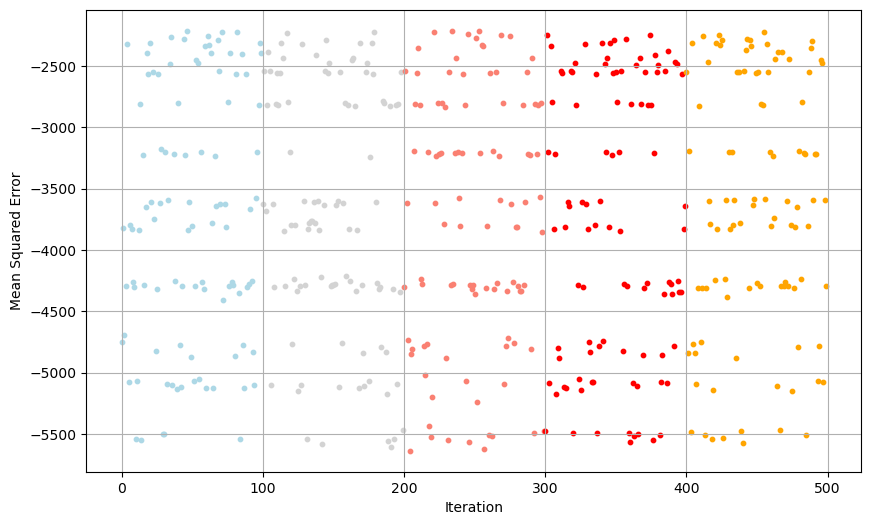

In [35]:
if Run_Code:

    def tune_random_forest_hyperparameters(X_train, y_train, cv_fold=5):
        # Define the hyperparameter grid
        grid = {
            'n_estimators': [50, 100, 125 , 150, 175,  200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [1, 2, 3, 5,10,20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2, 3, 4]
        }

        # Create the Random Forest model
        model_rf = RandomForestRegressor()

        # Perform randomized search for hyperparameter tuning
        tic = time.time()
        rando_search = RandomizedSearchCV(
            estimator=model_rf,
            param_distributions=grid,
            cv=cv_fold,
            n_iter=500,
            n_jobs=8,
            scoring='neg_mean_squared_error'
        )

        rando_result = rando_search.fit(X_, y_)

        # Print the results
        printstring = f"Randomized search performed in {time.time() - tic:.0f}s\n"
        printstring += f"Best Mean Squared Error: {-rando_result.best_score_:.4f}\n"

        for k, v in rando_result.best_params_.items():
            printstring += f"{k}: {v}\n"

        print(printstring)

        # Optionally, visualize the results
        visualize_search_results(rando_search)

   # Define a color mapping function based on iteration
    def get_color(iteration):
        if iteration < 100:
            return theme_color  # Color for iteration < 100
        elif iteration < 200:
            return 'lightgray'  # Color for iteration < 200
        elif iteration < 300:
            return 'salmon'  # Color for iteration < 300
        elif iteration < 400:
            return 'red'  
        else :
            return 'orange'

    def visualize_search_results(search_results):
        means = search_results.cv_results_['mean_test_score']
        params = search_results.cv_results_['params']

        # Plot the distribution of mean squared errors for different hyperparameters
        plt.figure(figsize=(10, 6))

        for i in range(len(means)):
            color = get_color(i)  # Determine the color based on iteration
            plt.scatter(i, means[i], c=color, s=10)

        graph_name('Randomized Search Results')
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error')
        plt.grid(True)
        plt.show()
    # Usage:
    tune_random_forest_hyperparameters(X_train, y_train, cv_fold=cv_fold)


In [36]:
print(f"The one that perform better was the grid search that give a Random forest model with those parameters : \n {best_params}")

The one that perform better was the grid search that give a Random forest model with those parameters : 
 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350, 'random_state': 42}


We will then use the Random Forest Regressor using the parameters obtained with the grid search algorith on the evaluate test set.

#### Evaluation :

In [37]:
df_rf = dummies_not_col_to_drop(df)

X = df_rf.drop(['usd_price_day'], axis = 1)
y = df_rf['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)


rf_model = RandomForestRegressor(**best_params)  

# Fit the model to your data
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_evaluate)

mse_rf  = mean_squared_error(y_evaluate,y_pred)
rmse_rf = np.sqrt(mse_rf)

print('MSE Random Forest =', mse_rf)
print('--------------------------------')
print('RMSE Random Forest =', rmse_rf)

MSE Random Forest = 2159.344900731611
--------------------------------
RMSE Random Forest = 46.46875187404554


#### **c) Neural Network :**

We will implement a neural network using the ReLU activation function for the hidden layers and linear regression for the output layer. Since we are working with linear models in this context, we will first remove the column we identified during the data preprocessing stage and scale our data.

#### Data set selection :

**Qualitative variables into dummies :**

We will try here the data set when we drop the column selected before, and without dropping them

In [38]:
df_nn = dummies_col_to_drop(df)
X = df_nn.drop(['usd_price_day'], axis = 1)
y = df_nn['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

n, d = X_train.shape

np.random.seed(seed)
tf.random.set_seed(seed)

# Define our neural network model
model = Sequential()
model.add(Dense(128, input_dim=d, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Fit the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)

clear_output(wait=True)
print('MSE Neural Network =', mse_nn)
print('--------------------------------')
print('RMSE Neural Network =', rmse_nn)


MSE Neural Network = 2055.0571797071725
--------------------------------
RMSE Neural Network = 45.33273849776972


In [39]:
df_lr = dummies_not_col_to_drop(df)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)
n, d = X_train.shape

np.random.seed(seed)
tf.random.set_seed(seed)

# Define our neural network model
model = Sequential()
model.add(Dense(128, input_dim=d, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Fit the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)

clear_output(wait=True)
print('MSE Neural Network (without droping columns) =', mse_nn)
print('--------------------------------')
print('RMSE Neural Network (without droping columns) =', rmse_nn)


MSE Neural Network (without droping columns) = 2047.5074967654618
--------------------------------
RMSE Neural Network (without droping columns) = 45.24939222537096


The model without dropping columns perform better

**Qualitative variables into quantitative variables:**

Let's try to just put our qualitative parameters into quantitative one to see if it perform better than the stuff we did previously

In [40]:
df_nn = integer_col_to_drop(df)
X = df_nn.drop(['usd_price_day'], axis = 1)
y = df_nn['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

n, d = X_train.shape

np.random.seed(seed)
tf.random.set_seed(seed)

# Define our neural network model

model = Sequential()
model.add(Dense(128, input_dim=d, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Fit the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_test)

clear_output(wait=True)
# Calculate the mean squared error
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)

print('MSE Neural Network =', mse_nn)
print('--------------------------------')
print('RMSE Neural Network =', rmse_nn)


MSE Neural Network = 2255.9831066786323
--------------------------------
RMSE Neural Network = 47.49719051353072


In [41]:
df_nn = integer_not_col_to_drop(df)
X = df_nn.drop(['usd_price_day'], axis = 1)
y = df_nn['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

n, d = X_train.shape

np.random.seed(seed)
tf.random.set_seed(seed)

# Define our neural network model

model = Sequential()
model.add(Dense(128, input_dim=d, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Fit the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_test)

clear_output(wait=True)
# Calculate the mean squared error
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)

print('MSE Neural Network (without dropping columns)  =', mse_nn)
print('--------------------------------')
print('RMSE Neural Network (without dropping columns) =', rmse_nn)


MSE Neural Network (without dropping columns)  = 2296.5996017895936
--------------------------------
RMSE Neural Network (without dropping columns) = 47.92285051819845


**Scale Data**:

It appears that transforming our categorical values into dummy variables yields better results. Now, let's assess how our algorithms perform when we scale the data.

In [42]:
df_nn = dummies_not_col_to_drop(df)
df_nn = scale_data(df_nn, selected_columns_n)
X = df_nn.drop(['usd_price_day'], axis = 1)
y = df_nn['usd_price_day']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)

n, d = X_train.shape

np.random.seed(seed)
tf.random.set_seed(seed)

# Define our neural network model

model = Sequential()
model.add(Dense(128, input_dim=d, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Fit the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_test)

clear_output(wait=True)
# Calculate the mean squared error
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)

print('MSE Neural Network =', mse_nn)
print('--------------------------------')
print('RMSE Neural Network =', rmse_nn)


MSE Neural Network = 2122.1226936304456
--------------------------------
RMSE Neural Network = 46.066502945529145


The data transformation that gives us the best performance on our base model is the one with dummy variables, without dropping any columns, and with unscaled data.

#### Regularization :

Let's now try to perform L1 and L2 regularization (lasso and ridge) on our input and hidden layers and see how they perform.

In [43]:
df_lr = dummies_not_col_to_drop(df)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X = scale_data(X,selected_columns_n)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)
n, d = X_train.shape

# Set a random seed
np.random.seed(seed)
tf.random.set_seed(seed)

alpha_to_try = [0, 0.001, 0.01, 0.1, 1]

# Define our neural network model
best_mse = []
best_alpha = None  # Initialize the variable to store the best alpha
best_rmse = None   # Initialize the variable to store the best RMSE

for alpha in alpha_to_try:
    model = Sequential()
    model.add(Dense(128, input_dim=d, activation='relu', kernel_regularizer=l1(alpha)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l1(alpha)))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the mean squared error and store it
    mse_nn = mean_squared_error(y_test, y_pred)
    best_mse.append(mse_nn)

    # Check if this is the best result so far
    if best_alpha is None or mse_nn < min(best_mse):
        best_alpha = alpha
        best_rmse = np.sqrt(mse_nn)

    # Clear the output because it took too much place
    clear_output(wait=True) 
    print('Trying alpha =', alpha)

clear_output(wait=True)
best_alphaL1 = best_alpha
mse_nn_L1 = np.min(best_mse)
rmse_nn = np.sqrt(mse_nn)

print('L1 :')
print('--------------------------------')
print('MSE Neural Network =', mse_nn_L1)
print('Best Alpha =', best_alphaL1)
print('Best RMSE =', best_rmse)
print('--------------------------------')


L1 :
--------------------------------
MSE Neural Network = 1961.1414322403084
Best Alpha = 0
Best RMSE = 47.191754396082494
--------------------------------


In [44]:
df_lr = dummies_not_col_to_drop(df)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X = scale_data(X, selected_columns_n)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)
n, d = X_train.shape

# Set a random seed
np.random.seed(seed)
tf.random.set_seed(seed)

alpha_to_try = [0, 0.001, 0.01, 0.1, 1]

# Define your neural network model
best_mse = []
best_alpha = None  # Initialize the variable to store the best alpha
best_rmse = None   # Initialize the variable to store the best RMSE

for alpha in alpha_to_try:
    model = Sequential()
    model.add(Dense(128, input_dim=d, activation='relu', kernel_regularizer=l2(alpha)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(alpha)))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the mean squared error and store it
    mse_nn = mean_squared_error(y_test, y_pred)
    best_mse.append(mse_nn)

    # Check if this is the best result so far
    if best_alpha is None or mse_nn < min(best_mse):
        best_alpha = alpha
        best_rmse = np.sqrt(mse_nn)

    # Clear the output because it took too much place
    clear_output(wait=True) 
    print('Trying alpha =', alpha)

clear_output(wait=True)
best_alphaL2 = best_alpha
mse_nn_L2 = np.min(best_mse)
rmse_nn = np.sqrt(mse_nn)

print('L2 :')
print('--------------------------------')
print('MSE Neural Network =', mse_nn_L2)
print('Best Alpha =', best_alphaL2)
print('Best RMSE =', best_rmse)
print('--------------------------------')

L2 :
--------------------------------
MSE Neural Network = 1906.966932673867
Best Alpha = 0
Best RMSE = 45.96420824352791
--------------------------------


We will select the model with L1 regularization since it performed better with alpha = 0.001, and use it as the basis for tuning the parameters of our neural networks.

#### Tuning Parameters of Our Neural Network:

In the initial phase of parameter tuning, we selected the model that performed the best without any regularization. Next, we fine-tuned the regularization term before making adjustments to the parameters of our neural network. We also explored the application of both L1 and L2 regularization techniques.

The training data for our model was previously chosen, consisting of scale data, columns with limited contribution not removed, and all qualitative variables converted into dummy variables. We chose L1 regularization with an alpha value of 0. It means that we don't add any regularization.

In [45]:
if mse_nn_L1 > mse_nn_L2 :
    best_alpha = best_alphaL2
else:
    best_alpha = best_alphaL1


# Function to build the Neural Networks
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=1),
                input_dim=d, activation=hp.Choice('activation_1', values=['relu', 'tanh']),kernel_regularizer=l2(best_alpha)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=1),
                activation=hp.Choice('activation_2', values=['relu', 'tanh']),kernel_regularizer=l2(best_alpha)))
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1, 1.0]))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model
              
              
start_time = time.time()

# Initialize the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Adjust the number of trials
    directory='my_tuner_directory'  # Create a directory to store tuner results
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and compile the best model
best_model = build_model(best_hps)

# Fit the best model on the training data
best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate the mean squared error
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)

end_time = time.time()
execution_time = end_time - start_time

#clear the output because it took too much place
clear_output(wait=True)
print('MSE Neural Network =', mse_nn)
print('--------------------------------')
print('RMSE Neural Network =', rmse_nn)
print('--------------------------------')
print('Execution Time:', execution_time, 'seconds')

# Output the chosen hyperparameters
print('Chosen Hyperparameters:')
print('units_1:', best_hps.get('units_1'))
print('activation_1:', best_hps.get('activation_1'))
print('units_2:', best_hps.get('units_2'))
print('activation_2:', best_hps.get('activation_2'))
print('learning_rate:', best_hps.get('learning_rate'))

# Delete the 'my_turner_directory' where we store the information from our hyper parameters 
if True:
    import shutil

    # Path to the tuner directory
    tuner_directory = 'my_tuner_directory'

    # Remove the tuner directory and its contents
    shutil.rmtree(tuner_directory)
    print('my_tuner_directory deleted')

MSE Neural Network = 2054.0461389188135
--------------------------------
RMSE Neural Network = 45.32158579439618
--------------------------------
Execution Time: 290.14751076698303 seconds
Chosen Hyperparameters:
units_1: 96
activation_1: relu
units_2: 62
activation_2: relu
learning_rate: 0.001
my_tuner_directory deleted


#### Evaluation :

It appears that our default model outperforms the one achieved through parameter tuning.

In [50]:
if mse_nn_L1 > mse_nn_L2 :
    best_alpha = best_alphaL2
else:
    best_alpha = best_alphaL1

df_lr = dummies_not_col_to_drop(df)

X = df_lr.drop(['usd_price_day'], axis = 1)
y = df_lr['usd_price_day']
X = scale_data(X,selected_columns_n)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = seed) 
X_evaluate, X_test, y_evaluate, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = seed)
n, d = X_train.shape

np.random.seed(seed)
tf.random.set_seed(seed)

# Define your neural network model
model = Sequential()
model.add(Dense(128, input_dim=d, activation='relu', kernel_regularizer=l1(best_alpha)))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(best_alpha)))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Fit the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_evaluate)

# Calculate the mean squared error
mse_nn = mean_squared_error(y_evaluate, y_pred)
rmse_nn = np.sqrt(mse_nn)

clear_output(wait=True)
print('MSE Neural Network (without droping columns) =', mse_nn)
print('--------------------------------')
print('RMSE Neural Network (without droping columns) =', rmse_nn)


MSE Neural Network (without droping columns) = 2413.8663659507274
--------------------------------
RMSE Neural Network (without droping columns) = 49.131114031240195


### 1.3) Conclusion :

In [51]:
table_name('MSE of each choosen model on the evaluate set')
print(f"+-----------------------+--------------------------------+")
print(f"|       Model           |   Mean Squared Error (MSE)     |")
print(f"+-----------------------+--------------------------------+")
print(f"| Linear Regression     |  MSE Linear Regression : {round(mse_lr,1)}|")
print(f"| Random Forest         |  MSE Random Forest :     {round(mse_rf,1)}|")
print(f"| Neural Networks       |  MSE Neural Networks :   {round(mse_nn,1)}|")
print(f"+-----------------------+--------------------------------+")


*Table 6 : MSE of each choosen model on the evaluate set* 


+-----------------------+--------------------------------+
|       Model           |   Mean Squared Error (MSE)     |
+-----------------------+--------------------------------+
| Linear Regression     |  MSE Linear Regression : 2703.6|
| Random Forest         |  MSE Random Forest :     2159.3|
| Neural Networks       |  MSE Neural Networks :   2413.9|
+-----------------------+--------------------------------+


The Random Forest algorithm is the model that performs better on the evaluation set.

In [48]:
end_time_project = time.time()

execution_time = end_time_project - start_time_project
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Execution time of the total project is: {minutes} minutes and {seconds} seconds")

Execution time of the total project is: 227 minutes and 59 seconds
